In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [24]:
import addict
import copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
from tqdm.notebook import tqdm
from typing import List, Dict, Tuple

import celeri

plt.rcParams[
    "text.usetex"
] = False  # Plotting the global model is much much faster with tex fonts turned off

# Read in data files, create storage dictionaries, and do basic processing

In [25]:
# Western North America example
# command_file_name = "../data/command/western_north_america_command.json"
# Japan model
command_file_name = "../data/command/japan_command.json"

In [26]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this works correctly

2024-06-27 09:29:44.929 | INFO     | celeri.celeri:get_logger:129 - Read: ../data/command/japan_command.json
2024-06-27 09:29:44.930 | INFO     | celeri.celeri:get_logger:130 - RUN_NAME: 2024-06-27-09-29-44
2024-06-27 09:29:44.930 | INFO     | celeri.celeri:get_logger:131 - Write log file: ../runs/2024-06-27-09-29-44/2024-06-27-09-29-44.log
2024-06-27 09:29:44.931 | INFO     | celeri.celeri:read_data:136 - Reading data files
2024-06-27 09:29:44.935 | SUCCESS  | celeri.celeri:read_data:140 - Read: ../data/segment/japan_segment.csv
2024-06-27 09:29:44.937 | SUCCESS  | celeri.celeri:read_data:145 - Read: ../data/block/japan_block.csv
2024-06-27 09:29:44.938 | SUCCESS  | celeri.celeri:read_data:152 - Read: ../data/mesh/japan_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

2024-06-27 09:29:45.006 | SUCCESS  | celeri.celeri:read_data:299 - Read: ../data/mesh/nankai.msh



Warning: The file contains tag data that couldn't be processed.

2024-06-27 09:29:45.050 | SUCCESS  | celeri.celeri:read_data:299 - Read: ../data/mesh/japan.msh



Warning: The file contains tag data that couldn't be processed.

2024-06-27 09:29:45.087 | SUCCESS  | celeri.celeri:read_data:299 - Read: ../data/mesh/sagami.msh
2024-06-27 09:29:45.091 | SUCCESS  | celeri.celeri:read_data:335 - Read: ../data/station/japan_station.csv
2024-06-27 09:29:45.092 | INFO     | celeri.celeri:read_data:350 - No mogi_file_name
2024-06-27 09:29:45.093 | INFO     | celeri.celeri:read_data:372 - No sar_file_name


# Get elastic operators and TDE smoothing operators

In [27]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-06-27 09:29:48.709 | INFO     | celeri.celeri:get_elastic_operators:1608 - Using precomputed elastic operators


# Calculate non-elastic operators

In [28]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)
celeri.get_tde_coupling_constraints(meshes, segment, block, operators)

2024-06-27 09:29:51.380 | INFO     | celeri.celeri:get_slip_rate_constraints:1223 - No slip rate constraints


# Plot input data

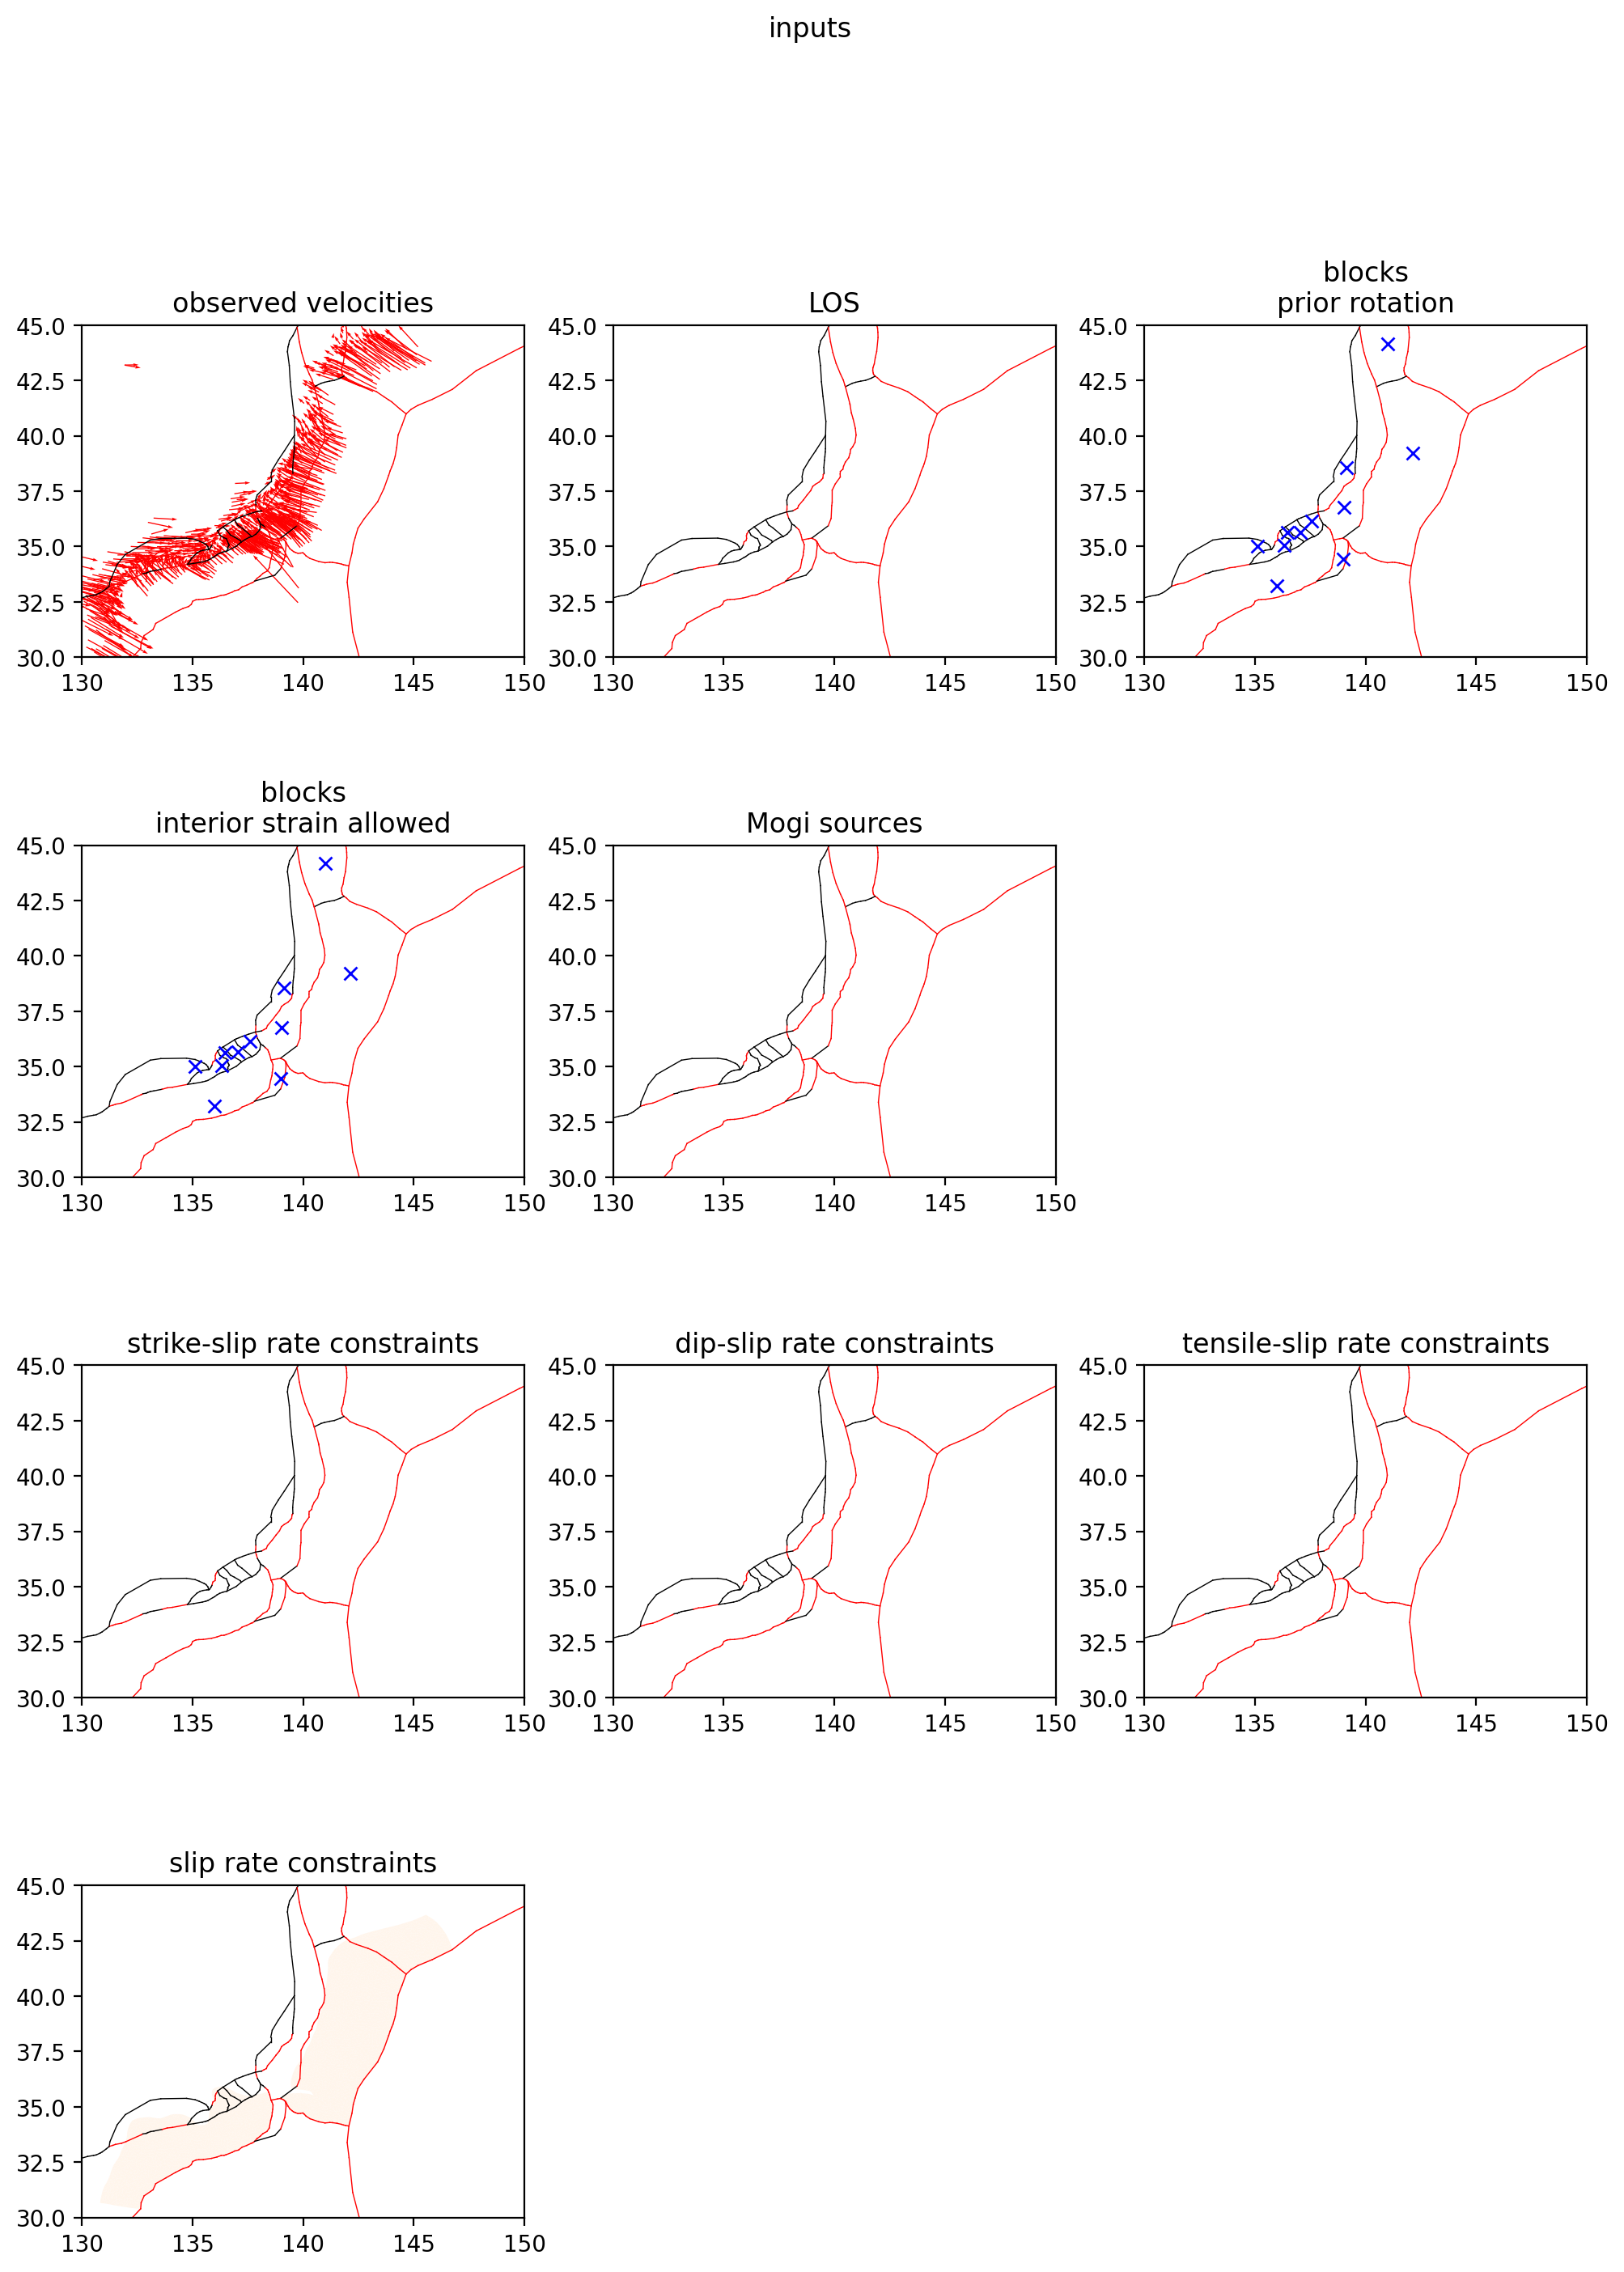

2024-06-27 09:29:59.176 | SUCCESS  | celeri.celeri:plot_input_summary:4496 - Wrote figures../runs/2024-06-27-09-29-44/plot_input_summary.(pdf, png)


<Figure size 640x480 with 0 Axes>

In [29]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{TDE \; coupling \; constraints = 0} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    -\phi(\mathrm{plate \; rotations \; to \; TDE \; slip \; rates)}    & \mathrm{identities}                & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [30]:
index, estimation = celeri.assemble_and_solve_dense(
    command, assembly, operators, station, block, meshes
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

In [23]:
print(index)

{'n_stations': 954, 'vertical_velocities': array([   2,    5,    8,   11,   14,   17,   20,   23,   26,   29,   32,
         35,   38,   41,   44,   47,   50,   53,   56,   59,   62,   65,
         68,   71,   74,   77,   80,   83,   86,   89,   92,   95,   98,
        101,  104,  107,  110,  113,  116,  119,  122,  125,  128,  131,
        134,  137,  140,  143,  146,  149,  152,  155,  158,  161,  164,
        167,  170,  173,  176,  179,  182,  185,  188,  191,  194,  197,
        200,  203,  206,  209,  212,  215,  218,  221,  224,  227,  230,
        233,  236,  239,  242,  245,  248,  251,  254,  257,  260,  263,
        266,  269,  272,  275,  278,  281,  284,  287,  290,  293,  296,
        299,  302,  305,  308,  311,  314,  317,  320,  323,  326,  329,
        332,  335,  338,  341,  344,  347,  350,  353,  356,  359,  362,
        365,  368,  371,  374,  377,  380,  383,  386,  389,  392,  395,
        398,  401,  404,  407,  410,  413,  416,  419,  422,  425,  428,
        

# Plot model summary

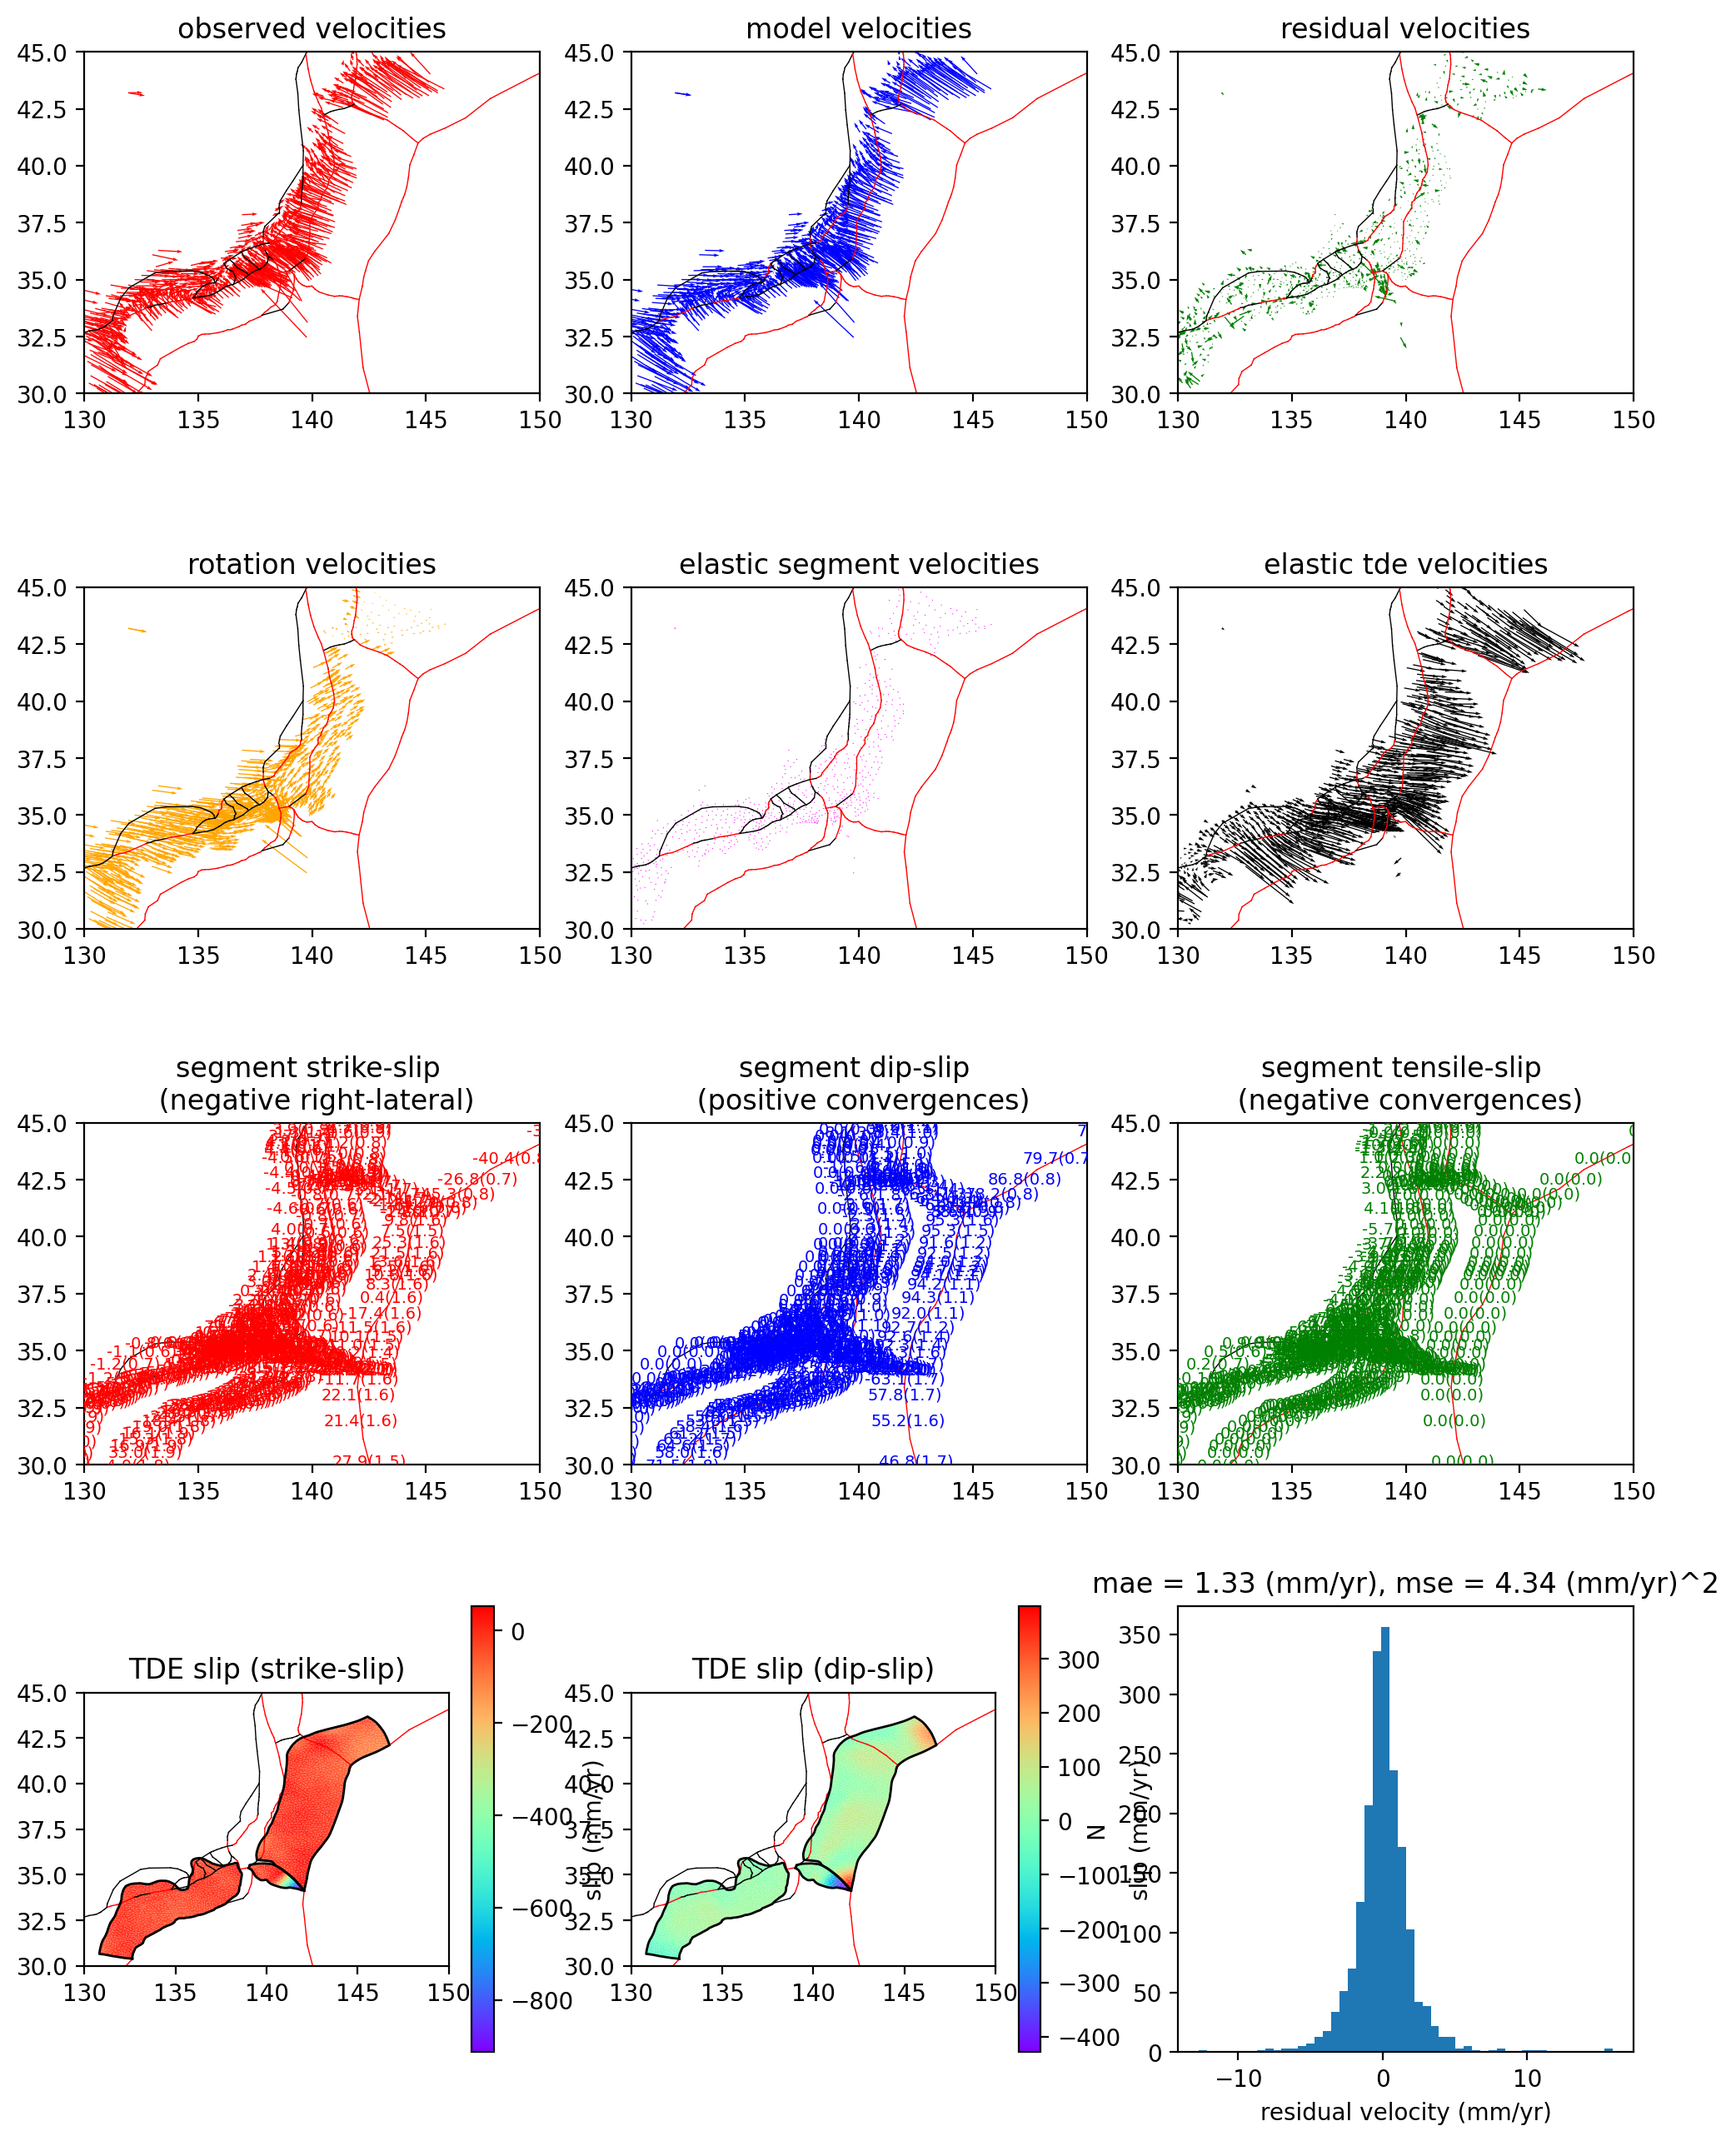

2024-06-27 09:31:07.009 | SUCCESS  | celeri.celeri:plot_estimation_summary:4996 - Wrote figures../runs/2024-06-27-09-29-44/plot_estimation_summary.(pdf, png)


<Figure size 640x480 with 0 Axes>

In [31]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

### Testing triangular coupling calculations

In [ ]:
# Calculate partials
tricoup = celeri.get_rotation_to_tri_slip_rate_partials(meshes[0], 0, segment, block)
# Do the projection of block motions
trislip = tricoup @ estimation.state_vector[0 : 3 * index.n_blocks]
# Isolate components
tristrike = trislip[0::3]
tridip = trislip[1::3]
tritens = trislip[2::3]
# Identify segments closest to each element
csi = np.unique(meshes[0].closest_segment_idx)

#### Visualize projected slip rates

In [ ]:
# plt.close('all')
import matplotlib
%matplotlib widget

import pyproj
GEOID = pyproj.Geod(ellps="WGS84")
segment_azimuth = np.zeros_like(segment.lon1)
for i in range(len(segment.lon1)):
    segment_azimuth[i], _, _ = GEOID.inv(segment.lon1[i], segment.lat1[i], segment.lon2[i], segment.lat2[i])
rhrstrike = segment_azimuth + 180

seg_flip = np.zeros_like(segment.lon1)
seg_flip[segment.lat2 < segment.lat1] = -1000
import matplotlib.colors as colors
fig1, ax = plt.subplots(1, 2)
i = 0
fill_value0 = tristrike
# fill_value0 = meshes[i].strike
# fill_value_range = [np.min(fill_value0), np.max(fill_value0)]
fill_value_range0 = [-20, 20]
x_coords = meshes[i].meshio_object.points[:, 0]
y_coords = meshes[i].meshio_object.points[:, 1]
vertex_array = np.asarray(meshes[i].verts)
xy = np.c_[x_coords, y_coords]
verts = xy[vertex_array]
pc0 = matplotlib.collections.PolyCollection(
    verts, edgecolor="none", cmap="rainbow"
)
pc0.set_array(
    fill_value0
)
pc0.set_clim(fill_value_range0)
ax[0].add_collection(pc0)
ax[0].scatter(segment.mid_lon[csi], segment.mid_lat[csi], vmin=fill_value_range0[0], vmax=fill_value_range0[1], c=estimation.strike_slip_rates[csi], cmap="rainbow")
# ax[0].scatter(segment.mid_lon[csi], segment.mid_lat[csi], vmin=fill_value_range0[0], vmax=fill_value_range0[1], c=seg_flip[csi], cmap="rainbow")
# ax.autoscale()
plt.colorbar(pc0, label="Strike-slip (mm/yr)", ax=ax[0])
# Add mesh edge
x_edge = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
y_edge = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
x_edge = np.append(x_edge, x_coords[meshes[0].ordered_edge_nodes[0, 0]])
y_edge = np.append(y_edge, y_coords[meshes[0].ordered_edge_nodes[0, 0]])
ax[0].plot(x_edge, y_edge, color="black", linewidth=1)
ax[0].axis('equal')


fill_value1 = tridip
# fill_value = meshes[i].dip
fill_value_range = [np.min(fill_value1), np.max(fill_value1)]
# fill_value_range = [-35, 35]
x_coords = meshes[i].meshio_object.points[:, 0]
y_coords = meshes[i].meshio_object.points[:, 1]
vertex_array = np.asarray(meshes[i].verts)
xy = np.c_[x_coords, y_coords]
verts = xy[vertex_array]
pc1 = matplotlib.collections.PolyCollection(
    verts, edgecolor="none", cmap="rainbow"
)
pc1.set_array(
    fill_value1
)

ax[1].add_collection(pc1)
pc1.set_clim(fill_value_range)
ax[1].scatter(segment.mid_lon[csi], segment.mid_lat[csi], vmin=fill_value_range[0], vmax=fill_value_range[1], c=-estimation.tensile_slip_rates[csi], cmap="rainbow")
# ax.autoscale()
plt.colorbar(pc1, label="Dip-slip (mm/yr)", ax=ax[1])
# Add mesh edge
x_edge = x_coords[meshes[i].ordered_edge_nodes[:, 0]]
y_edge = y_coords[meshes[i].ordered_edge_nodes[:, 0]]
x_edge = np.append(x_edge, x_coords[meshes[0].ordered_edge_nodes[0, 0]])
y_edge = np.append(y_edge, y_coords[meshes[0].ordered_edge_nodes[0, 0]])
ax[1].plot(x_edge, y_edge, color="black", linewidth=1)
ax[1].axis('equal')

fig1.tight_layout()
print(estimation.strike_slip_rates[csi])
print(estimation.tensile_slip_rates[csi])
